In [1]:
import os, sys
HOME_DIR = os.path.join(os.getcwd(), '..')
sys.path.append(HOME_DIR)
import yaml
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import rdkit
from rdkit import Chem
import torch
from torch_geometric.loader import DataLoader
from substrate_metric_learning.networks import Net
from substrate_metric_learning.utils import *
from substrate_metric_learning.features import smiles_to_graph_substrate, smiles_to_graph
from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.model_selection import LeaveOneOut
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import r2_score
from sklearn.feature_selection import mutual_info_regression, f_regression
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.compose import TransformedTargetRegressor
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, HistGradientBoostingRegressor, ExtraTreesRegressor
import sklearn
import random
import autosklearn.regression
from tdc.chem_utils import MolConvert

from sklearn.datasets import make_circles, make_classification, make_moons
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier

In [13]:
def snr_distance(ri, rj):
    return 2*np.var(ri - rj) / (np.var(ri) + np.var(rj))

In [14]:
config_path = os.path.join(HOME_DIR, "configs/hparams_default.yaml")
config = Objdict(yaml.safe_load(open(config_path)))
input_dim = 133
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model_pretrained = Net(input_dim, config.hidden_channels, 1, config.num_layers, config.pool).to(device)
model_pretrained.load_state_dict(torch.load("/home/whgao/substrate_metric_learning/results/default/gin_epoch_56_sum_r2_1.538.pth"))
model_untrained = Net(input_dim, config.hidden_channels, 1, config.num_layers, config.pool).to(device)
model_untrained.load_state_dict(torch.load("/home/whgao/substrate_metric_learning/results/default/gin_epoch_0.pth"))

<All keys matched successfully>

In [15]:
test_doyle_smiles = [
    "C(Br)1=CC(C2OC(C=O)=CC=2)=CC=C1",
    "C(Br)1=CC(C2=CC=C(F)C=C2)=CC=C1",
    "C1=C(F)C(OC)=CC(C)=C1Br",
    "C(C#N)1=CC=C(OC)C=C1Br",
    "C1=CC(S(=O)(N2CCOCC2)=O)=CC=C1Br",
    "C1=C(S(=O)(C)=O)C=CC(C)=C1Br",
    "C1=CC(N2CCN(C(=O)OC(C)(C)C)CC2)=C(Cl)C=C1Br",
    "C1=C(C#N)C(F)=CC=C1Br",
    "C1=CC(C(=O)CCC(=O)OC)=CC=C1Br",
    "C1=CC(C2=CNC=N2)=CC=C1Br",
    "C(COC)1=CC=CC(OC)=C1Br",
    "C(Cl)1=CC=C(C(C)(C)C)C=C1Br",
    "C1=C(OC(F)(F)F)C=C(Cl)C=C1Br",
    "C1=CC=C(C(=O)OCC)C(C)=C1Br",
    "C(F)1=CC=C(C(C)(C)C)C=C1Br"
]

test_doyle_yields = [
    0.21, 
    0.47,
    0.28,
    0.95,
    0.82,
    0.95,
    0.0,
    0.79,
    0.78,
    0.28,
    0.0,
    0.55,
    0.65,
    0.7,
    0.72
]

patt_aryl_halide = Chem.MolFromSmarts('c-[Br]')
temp = [Chem.MolFromSmiles(smi).GetSubstructMatch(patt_aryl_halide) for smi in test_doyle_smiles]

data_doyle = pd.DataFrame({
    "smiles": test_doyle_smiles,
    "label": test_doyle_yields,
    "aroma_c_index": [_[0] for _ in temp],
    "halide_index": [_[1] for _ in temp]
})

embeddings = get_embedding_from_smi(data_doyle.smiles.to_list(), data_doyle.aroma_c_index.to_list(), model_pretrained, device)

In [24]:
embeddings = get_embedding_from_smi(data_doyle.smiles.to_list(), data_doyle.aroma_c_index.to_list(), model_pretrained, device)
highest = 0

for n_feat in [3]:
    for n_neighbors in [3, 5, 7]:
        for w in ['uniform', 'distance']:
            for dist in ['l1', 'l2', 'cosine']:
                for seed in np.arange(100):

                    y = data_doyle['label'].values
                    X = embeddings
                    loo = LeaveOneOut()
                    ys_pred = []
                    ys_true = []

                    np.random.seed(seed)
                    random.seed(seed)

                    for i, (train_index, test_index) in enumerate(loo.split(X)):
                        X_train, X_test = X[train_index], X[test_index]
                        y_train, y_test = y[train_index], y[test_index]

                        mut_info = mutual_info_regression(X_train, y_train)
                        X_train = X_train[:, np.argsort(mut_info)[::-1][:n_feat]]
                        X_train.reshape(-1, n_feat)
                        X_test = X_test[:, np.argsort(mut_info)[::-1][:n_feat]]
                        X_test.reshape(-1, n_feat)

                        reg = KNeighborsRegressor(n_neighbors=n_neighbors, weights=w, metric=dist)
                        # reg = SVR(kernel='rbf', C=1e3, gamma=0.1)
                        # reg = RandomForestRegressor(max_depth=5, random_state=0, n_estimators=10)
                        predictor = make_pipeline(StandardScaler(), TransformedTargetRegressor(regressor=reg, transformer=StandardScaler()))
                        predictor.fit(X_train, y_train)
                        y_pred = predictor.predict(X_test)
                        if y_pred[0] > 1:
                            y_pred[0] = 1
                        if y_pred[0] < 0:
                            y_pred[0] = 0
                        ys_pred.append(y_pred[0])
                        ys_true.append(y_test[0])

                    print(f"# features; {n_feat:2d}, # neighbors: {n_neighbors:2d}, type: {w}, distance: {dist}, R2: {r2_score(ys_true, ys_pred):.3f}")
                    if r2_score(ys_true, ys_pred) > highest:
                        highest = r2_score(ys_true, ys_pred)
                        best_params = {
                            "n_feat": n_feat,
                            "n_neighbors": n_neighbors,
                            "w": w,
                            "dist": dist,
                            "seed": seed,
                            "r2": highest
                        }
print(best_params)

# features;  3, # neighbors:  3, type: uniform, distance: l1, R2: 0.315
# features;  3, # neighbors:  3, type: uniform, distance: l1, R2: 0.282
# features;  3, # neighbors:  3, type: uniform, distance: l1, R2: 0.375
# features;  3, # neighbors:  3, type: uniform, distance: l1, R2: 0.394
# features;  3, # neighbors:  3, type: uniform, distance: l1, R2: 0.282
# features;  3, # neighbors:  3, type: uniform, distance: l1, R2: 0.396
# features;  3, # neighbors:  3, type: uniform, distance: l1, R2: 0.305
# features;  3, # neighbors:  3, type: uniform, distance: l1, R2: 0.315
# features;  3, # neighbors:  3, type: uniform, distance: l1, R2: 0.315
# features;  3, # neighbors:  3, type: uniform, distance: l1, R2: 0.355
# features;  3, # neighbors:  3, type: uniform, distance: l1, R2: 0.297
# features;  3, # neighbors:  3, type: uniform, distance: l1, R2: 0.365
# features;  3, # neighbors:  3, type: uniform, distance: l1, R2: 0.371
# features;  3, # neighbors:  3, type: uniform, distance: l1, R2

R2 score:  0.514368562679781


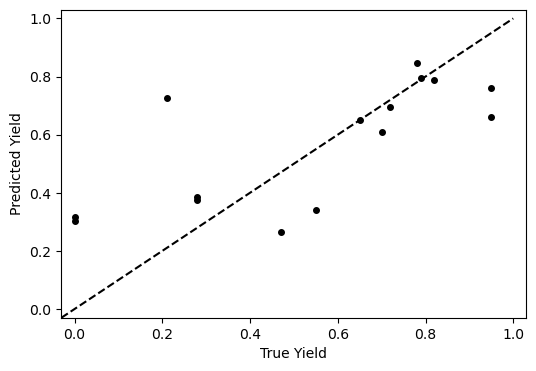

In [21]:
embeddings = get_embedding_from_smi(data_doyle.smiles.to_list(), data_doyle.aroma_c_index.to_list(), model_pretrained, device)

np.random.seed(88)
random.seed(88)

n_feat = 3
n_neighbors = 5
w = 'uniform'
dist = 'cosine'

y = data_doyle['label'].values
X = embeddings
loo = LeaveOneOut()
ys_pred = []
ys_true = []

for i, (train_index, test_index) in enumerate(loo.split(X)):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

    mut_info = mutual_info_regression(X_train, y_train)
    X_train = X_train[:, np.argsort(mut_info)[::-1][:n_feat]]
    X_train.reshape(-1, n_feat)
    X_test = X_test[:, np.argsort(mut_info)[::-1][:n_feat]]
    X_test.reshape(-1, n_feat)

    reg = KNeighborsRegressor(n_neighbors=n_neighbors, weights=w, metric=dist)
    predictor = make_pipeline(StandardScaler(), TransformedTargetRegressor(regressor=reg, transformer=StandardScaler()))
    predictor.fit(X_train, y_train)
    y_pred = predictor.predict(X_test)
    ys_pred.append(y_pred[0])
    ys_true.append(y_test[0])

print("R2 score: ", r2_score(ys_true, ys_pred))
# plot two subplots
# f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
# ax1.scatter(ys_true, ys_pred, s=16)
# ax1.plot([0, 1], [0, 1], c='r')
# ax1.set_xlim(-0.1, 1.1)
# ax1.set_ylim(-0.1, 1.1)
# ax1.set_xlabel("True yield")
# ax1.set_ylabel("Predicted yield")
# ax1.set_title("Predicted Yield vs. True values")
# ax1.grid()

# ax2.scatter(X[:, 0], y, s=16)
# ax2.set_xlabel("Embedding")
# ax2.set_ylabel("Yield")
# ax2.set_title("Embedding vs. Yield on Doyle Dataset")
# ax2.grid()

# plt.show()

f, ax = plt.subplots(1, 1, figsize=(6, 4))
ax.scatter(ys_true, ys_pred, s=16, c='black')
ax.plot([-0.03, 1], [-0.03, 1], '--', c='black')
ax.set_xlim(-0.03, 1.03)
ax.set_ylim(-0.03, 1.03)
ax.set_xlabel("True Yield")
ax.set_ylabel("Predicted Yield")
# ax.legend(loc='upper left')
# ax.spines['top'].set_visible(False)
# ax.spines['right'].set_visible(False)

# plt.show()
# plt.savefig("doyle_pair.png", dpi=200, bbox_inches='tight')
save_fig(ax, './doyle_pair.pdf')

In [30]:
np.mean(np.abs(np.array(ys_true) - np.array(ys_pred)))

0.16306666666666664

In [8]:
temp = pd.DataFrame({
    'smiles': data_doyle.smiles.to_list(),
    'experimental yield':ys_true,
    'predicted yield': ys_pred
})

temp

,smiles,experimental yield,predicted yield
0,C(Br)1=CC(C2OC(C=O)=CC=2)=CC=C1,0.21,0.726
1,C(Br)1=CC(C2=CC=C(F)C=C2)=CC=C1,0.47,0.264
2,C1=C(F)C(OC)=CC(C)=C1Br,0.28,0.386
3,C(C#N)1=CC=C(OC)C=C1Br,0.95,0.762
4,C1=CC(S(=O)(N2CCOCC2)=O)=CC=C1Br,0.82,0.788
5,C1=C(S(=O)(C)=O)C=CC(C)=C1Br,0.95,0.660
6,C1=CC(N2CCN(C(=O)OC(C)(C)C)CC2)=C(Cl)C=C1Br,0.00,0.316
7,C1=C(C#N)C(F)=CC=C1Br,0.79,0.794
8,C1=CC(C(=O)CCC(=O)OC)=CC=C1Br,0.78,0.846
9,C1=CC(C2=CNC=N2)=CC=C1Br,0.28,0.376


In [ ]:
transformer = MolConvert(src = 'SMILES', dst = 'Morgan')
transformer('C(Br)1=CC(C2OC(C=O)=CC=2)=CC=C1')

In [17]:
np.random.seed(88)
random.seed(88)

n_feat = 3
n_neighbors = 5
w = 'uniform'
dist = 'cosine'

y = data_doyle['label'].values

embedding_list = ['scope', 'rdkit2d', 'maccs', 'morgan', 'masking', 'chemgpt']

results = []

for embedding in embedding_list:
    if embedding == 'scope':
        X = get_embedding_from_smi(data_doyle.smiles.to_list(), data_doyle.aroma_c_index.to_list(), model_pretrained, device)
    elif embedding == 'rdkit2d':
        transformer = MolConvert(src = 'SMILES', dst = 'RDKit2D')
        X = transformer(data_doyle.smiles.to_list())
    elif embedding == 'maccs':
        transformer = MolConvert(src = 'SMILES', dst = 'MACCS')
        X = transformer(data_doyle.smiles.to_list())
    elif embedding == 'morgan':
        transformer = MolConvert(src = 'SMILES', dst = 'Morgan')
        X = transformer(data_doyle.smiles.to_list())
    elif embedding == 'masking':
        from molfeat.trans.pretrained import PretrainedDGLTransformer
        transformer = PretrainedDGLTransformer(kind='gin_supervised_masking', dtype=float)
        X = transformer(data_doyle.smiles.to_list())
    elif embedding == 'chemgpt':
        from molfeat.trans.pretrained.hf_transformers import PretrainedHFTransformer
        transformer = PretrainedHFTransformer(kind='ChemGPT-4.7M', notation='selfies', dtype=float)
        X = transformer(data_doyle.smiles.to_list())

    model_list = ['knn', 'linear', 'lasso', 'ridge', 'rf', 'svr']
    r_2s = []

    for model in model_list:

        loo = LeaveOneOut()
        ys_pred = []
        ys_true = []

        for i, (train_index, test_index) in enumerate(loo.split(X)):
            X_train, X_test = X[train_index], X[test_index]
            y_train, y_test = y[train_index], y[test_index]

            mut_info = mutual_info_regression(X_train, y_train)
            X_train = X_train[:, np.argsort(mut_info)[::-1][:n_feat]]
            X_train.reshape(-1, n_feat)
            X_test = X_test[:, np.argsort(mut_info)[::-1][:n_feat]]
            X_test.reshape(-1, n_feat)

            if model == 'linear':
                reg = LinearRegression()
            elif model == 'knn':
                reg = KNeighborsRegressor(n_neighbors=n_neighbors, weights=w, metric=dist)
            elif model == 'lasso':
                reg = Lasso(alpha=0.1)
            elif model == 'ridge':
                reg = Ridge(alpha=.5)
            elif model == 'svr':
                reg = SVR(kernel='rbf', C=1.0, epsilon=0.2)
            elif model == 'rf':
                reg = RandomForestRegressor(max_depth=5, random_state=0, n_estimators=10)
        
            predictor = make_pipeline(StandardScaler(), TransformedTargetRegressor(regressor=reg, transformer=StandardScaler()))
            predictor.fit(X_train, y_train)
            y_pred = predictor.predict(X_test)
            if y_pred[0] > 1:
                y_pred[0] = 1
            if y_pred[0] < 0:
                y_pred[0] = 0
            ys_pred.append(y_pred[0])
            ys_true.append(y_test[0])

        r_2s.append(r2_score(ys_true, ys_pred))
    results.append(r_2s)

results = np.array(results)
results = pd.DataFrame(results, columns=model_list, index=embedding_list)
results

,knn,linear,lasso,ridge,rf,svr
scope,0.514369,0.411950,0.341508,0.356147,0.219617,0.038809
rdkit2d,-0.585532,-0.405995,-0.261836,-0.198020,-0.810661,-0.615656
maccs,-0.384479,-0.332350,-0.403362,-0.534536,-1.042729,-0.580688
morgan,-0.669486,-0.757610,-0.705764,-0.878328,-1.032326,-0.873496
masking,-0.602134,-1.351068,-0.953604,-1.307892,-0.512206,-0.747437
chemgpt,-0.219361,0.274179,0.117934,0.202254,0.124776,0.090628


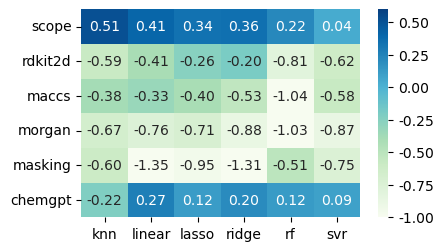

In [23]:

a = 0.45
fig, ax = plt.subplots(figsize=(10*a, 6*a))

sns.heatmap(results, annot=True, fmt='.2f', ax=ax, cmap='GnBu', xticklabels="auto", yticklabels="auto",
            cbar_kws={'shrink': 1.0, 'location': 'right', 'format': "{x:.2f}", 'spacing': 'proportional'}, vmin=-1, vmax=0.6)
# set the range of color bar in seaborn


# plt.show()
plt.savefig('yield_pred_doyle.png', dpi=400, bbox_inches='tight', transparent=True)

In [4]:
test_sigman_smiles = [
    "C1C(I)=CC=C(OC)C=1",
    "C1C=C(C)C=CC=1I",
    "C1C(I)=CC=CC=1",
    "C1C=C(F)C=CC=1I",
    "C1C(I)=CC=C(Cl)C=1",
    "C1C=C(C(F)(F)F)C=CC=1I",
    "C1C(I)=CC=C(C#N)C=1",
    "C1C(Cl)=CC=CC=1I",
    "C1C(I)=CC=CC=1C",
    "C1C(OC)=CC=CC=1I",
    "C1C(I)=CC=CC=1C#N",
    "C1C(C(F)(F)F)=CC(C(F)(F)F)=CC=1I",
]

test_sigman_log_kx_kh1 = [
    -0.112,
    0.022,
    0.000,
    0.045,
    0.332,
    0.759,
    1.113,
    0.617,
    0.171,
    0.250,
    0.694,
    1.093,
]

test_sigman_log_kx_kh2 = [
    -0.157,
    0.041,
    0.000,
    -0.050,
    0.245,
    0.676,
    1.072,
    0.557,
    0.140,
    0.192,
    0.622,
    1.113,
]

test_sigman_log_kx_kh4 = [
    -0.105,
    0.041,
    0.000,
    -0.050,
    0.245,
    0.676,
    1.072,
    0.557,
    0.140,
    0.192,
    0.622,
    1.113,
]

patt_aryl_halide = Chem.MolFromSmarts('c-[I]')
temp = [Chem.MolFromSmiles(smi).GetSubstructMatch(patt_aryl_halide) for smi in test_sigman_smiles]

data_sigman = pd.DataFrame({
    "smiles": test_sigman_smiles,
    "label": test_sigman_log_kx_kh1,
    "aroma_c_index": [_[0] for _ in temp],
    "halide_index": [_[1] for _ in temp]
})

embeddings = get_embedding_from_smi(data_sigman.smiles.to_list(), data_sigman.aroma_c_index.to_list(), model_pretrained, device)

In [16]:
embeddings = get_embedding_from_smi(data_sigman.smiles.to_list(), data_sigman.aroma_c_index.to_list(), model_pretrained, device)
highest = 0

for n_feat in range(1, 9):
    # for n_neighbors in range(1, 9):
    #     for w in ['uniform', 'distance']:
    #         for dist in ['l1', 'l2', 'cosine']:

    y = data_sigman['label'].values
    X = embeddings
    loo = LeaveOneOut()
    ys_pred = []
    ys_true = []

    np.random.seed(0)
    random.seed(0)

    for i, (train_index, test_index) in enumerate(loo.split(X)):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]

        mut_info = mutual_info_regression(X_train, y_train)
        X_train = X_train[:, np.argsort(mut_info)[::-1][:n_feat]]
        X_train.reshape(-1, n_feat)
        X_test = X_test[:, np.argsort(mut_info)[::-1][:n_feat]]
        X_test.reshape(-1, n_feat)

        # reg = KNeighborsRegressor(n_neighbors=n_neighbors, weights=w, metric=dist)
        # reg = SVR(kernel='rbf', C=1e3, gamma=0.1)
        reg = RandomForestRegressor(max_depth=5, random_state=0, n_estimators=5)
        predictor = make_pipeline(StandardScaler(), TransformedTargetRegressor(regressor=reg, transformer=StandardScaler()))
        predictor.fit(X_train, y_train)
        y_pred = predictor.predict(X_test)
        ys_pred.append(y_pred[0])
        ys_true.append(y_test[0])

    print(f"# features; {n_feat:2d}, # neighbors: {n_neighbors:2d}, type: {w}, distance: {dist}, R2: {r2_score(ys_true, ys_pred):.3f}")
    if r2_score(ys_true, ys_pred) > highest:
        highest = r2_score(ys_true, ys_pred)
        best_params = {
            "n_feat": n_feat,
            "n_neighbors": n_neighbors,
            "w": w,
            "dist": dist,
            "r2": highest
        }
print(best_params)

# features;  1, # neighbors:  1, type: uniform, distance: l1, R2: -1.302
# features;  2, # neighbors:  1, type: uniform, distance: l1, R2: -0.495
# features;  3, # neighbors:  1, type: uniform, distance: l1, R2: -0.341
# features;  4, # neighbors:  1, type: uniform, distance: l1, R2: -0.189
# features;  5, # neighbors:  1, type: uniform, distance: l1, R2: -0.114
# features;  6, # neighbors:  1, type: uniform, distance: l1, R2: -0.128
# features;  7, # neighbors:  1, type: uniform, distance: l1, R2: -0.156
# features;  8, # neighbors:  1, type: uniform, distance: l1, R2: -0.243


NameError: name 'best_params' is not defined

R2 score:  0.5221200099992371


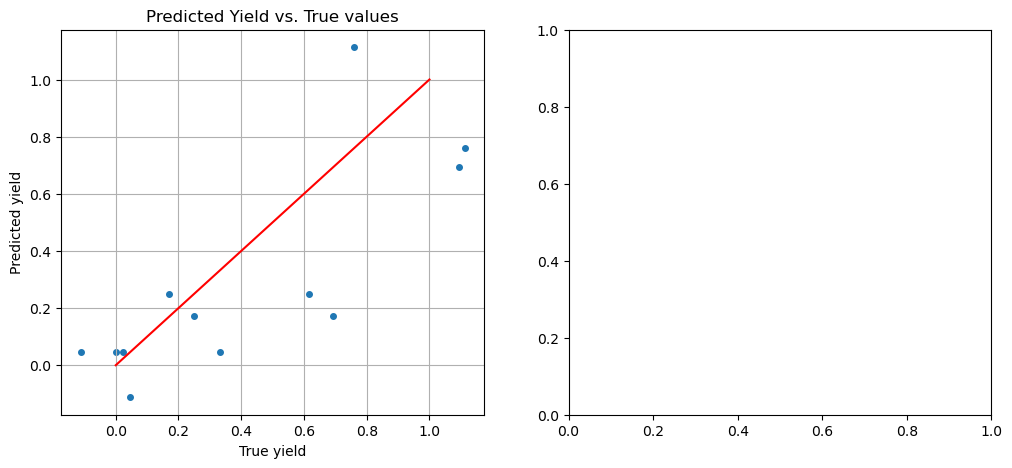

In [5]:
embeddings = get_embedding_from_smi(data_sigman.smiles.to_list(), data_sigman.aroma_c_index.to_list(), model_pretrained, device)

np.random.seed(1)
random.seed(1)

n_feat = 7
n_neighbors = 1
w = 'uniform'
dist = 'l1'

y = data_sigman['label'].values
X = embeddings
loo = LeaveOneOut()
ys_pred = []
ys_true = []

for i, (train_index, test_index) in enumerate(loo.split(X)):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

    mut_info = mutual_info_regression(X_train, y_train)
    X_train = X_train[:, np.argsort(mut_info)[::-1][:n_feat]]
    X_train.reshape(-1, n_feat)
    X_test = X_test[:, np.argsort(mut_info)[::-1][:n_feat]]
    X_test.reshape(-1, n_feat)

    reg = KNeighborsRegressor(n_neighbors=n_neighbors, weights=w, metric=dist)
    # reg = SVR(kernel='linear', C=1e3, gamma=0.1)
    # reg = RandomForestRegressor(max_depth=2, random_state=0, n_estimators=15)
    predictor = make_pipeline(StandardScaler(), TransformedTargetRegressor(regressor=reg, transformer=StandardScaler()))
    predictor.fit(X_train, y_train)
    y_pred = predictor.predict(X_test)
    ys_pred.append(y_pred[0])
    ys_true.append(y_test[0])

print("R2 score: ", r2_score(ys_true, ys_pred))
# plot two subplots
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
ax1.scatter(ys_true, ys_pred, s=16)
ax1.plot([0, 1], [0, 1], c='r')
# ax1.set_xlim(-0.1, 1.1)
# ax1.set_ylim(-0.1, 1.1)
ax1.set_xlabel("True yield")
ax1.set_ylabel("Predicted yield")
ax1.set_title("Predicted Yield vs. True values")
ax1.grid()


plt.show()

In [22]:
# Branch-Selective Hydroarylation: Iodoarene−Olefin Cross-Coupling

test_shenvi_smiles = [
    "C1=C(C#N)C=CC(I)=C1",
    "C1C=C(I)C=CC=1C(OC)=O",
    "C(F)1C=C(F)C=C(I)C=1",
    "C1(C=C(I)C=C(C(F)(F)F)C=1)C(F)(F)F",
    "C1C(OC)=CC=C(I)C=1",
    "C(O)1C=C(I)C=CC=1",
    "C1C=CC=C(I)C=1",
    "C1C=C(I)C=CC=1C",
    "C1C(CO)=CC=C(I)C=1",
    "C(Cl)1C=C(I)C=CN=1",
    "N(S(C1=CC=C(C)C=C1)(=O)=O)1C=C(I)C=N1",
    "S1C(I)=CC=C1",
    "C12C=CN(C(=O)OC(C)(C)C)C1=CC=C(I)C=2",
    "C(I)1=CC=CC2=CC=CC=C12",
    "C1=CC(I)=CC=C1Cl",
]

test_shenvi_yield = [
    0.83,
    0.72,
    0.79,
    0.78,
    0.55,
    0.71,
    0.56,
    0.63,
    0.70,
    0.60,
    0.80,
    0.67,
    0.61,
    0.37,
    0.71,
]

patt_aryl_halide = Chem.MolFromSmarts('c-[I]')
temp = [Chem.MolFromSmiles(smi).GetSubstructMatch(patt_aryl_halide) for smi in test_shenvi_smiles]

data_shenvi = pd.DataFrame({
    "smiles": test_shenvi_smiles,
    "label": test_shenvi_yield,
    "aroma_c_index": [_[0] for _ in temp],
    "halide_index": [_[1] for _ in temp]
})

embeddings = get_embedding_from_smi(data_shenvi.smiles.to_list(), data_shenvi.aroma_c_index.to_list(), model_pretrained, device)

In [23]:
embeddings = get_embedding_from_smi(data_shenvi.smiles.to_list(), data_shenvi.aroma_c_index.to_list(), model_pretrained, device)
highest = 0

for n_feat in range(1, 9):
    for n_neighbors in range(1, 9):
        for w in ['uniform', 'distance']:
            for dist in ['l1', 'l2', 'cosine']:

                y = data_shenvi['label'].values
                X = embeddings
                loo = LeaveOneOut()
                ys_pred = []
                ys_true = []

                np.random.seed(0)
                random.seed(0)

                for i, (train_index, test_index) in enumerate(loo.split(X)):
                    X_train, X_test = X[train_index], X[test_index]
                    y_train, y_test = y[train_index], y[test_index]

                    mut_info = mutual_info_regression(X_train, y_train)
                    X_train = X_train[:, np.argsort(mut_info)[::-1][:n_feat]]
                    X_train.reshape(-1, n_feat)
                    X_test = X_test[:, np.argsort(mut_info)[::-1][:n_feat]]
                    X_test.reshape(-1, n_feat)

                    reg = KNeighborsRegressor(n_neighbors=n_neighbors, weights=w, metric=dist)
                    # reg = SVR(kernel='rbf', C=1e3, gamma=0.1)
                    # reg = RandomForestRegressor(max_depth=5, random_state=0, n_estimators=5)
                    predictor = make_pipeline(StandardScaler(), TransformedTargetRegressor(regressor=reg, transformer=StandardScaler()))
                    predictor.fit(X_train, y_train)
                    y_pred = predictor.predict(X_test)
                    ys_pred.append(y_pred[0])
                    ys_true.append(y_test[0])

                print(f"# features; {n_feat:2d}, # neighbors: {n_neighbors:2d}, type: {w}, distance: {dist}, R2: {r2_score(ys_true, ys_pred):.3f}")
                if r2_score(ys_true, ys_pred) > highest:
                    highest = r2_score(ys_true, ys_pred)
                    best_params = {
                        "n_feat": n_feat,
                        "n_neighbors": n_neighbors,
                        "w": w,
                        "dist": dist,
                        "r2": highest
                    }
print(best_params)

# features;  1, # neighbors:  1, type: uniform, distance: l1, R2: -0.969
# features;  1, # neighbors:  1, type: uniform, distance: l2, R2: -0.969
# features;  1, # neighbors:  1, type: uniform, distance: cosine, R2: -1.039
# features;  1, # neighbors:  1, type: distance, distance: l1, R2: -0.969
# features;  1, # neighbors:  1, type: distance, distance: l2, R2: -0.969
# features;  1, # neighbors:  1, type: distance, distance: cosine, R2: -1.039
# features;  1, # neighbors:  2, type: uniform, distance: l1, R2: -0.800
# features;  1, # neighbors:  2, type: uniform, distance: l2, R2: -0.800
# features;  1, # neighbors:  2, type: uniform, distance: cosine, R2: -1.130
# features;  1, # neighbors:  2, type: distance, distance: l1, R2: -0.556
# features;  1, # neighbors:  2, type: distance, distance: l2, R2: -0.556
# features;  1, # neighbors:  2, type: distance, distance: cosine, R2: -1.130
# features;  1, # neighbors:  3, type: uniform, distance: l1, R2: -0.653
# features;  1, # neighbors: 

R2 score:  0.07463892369583924


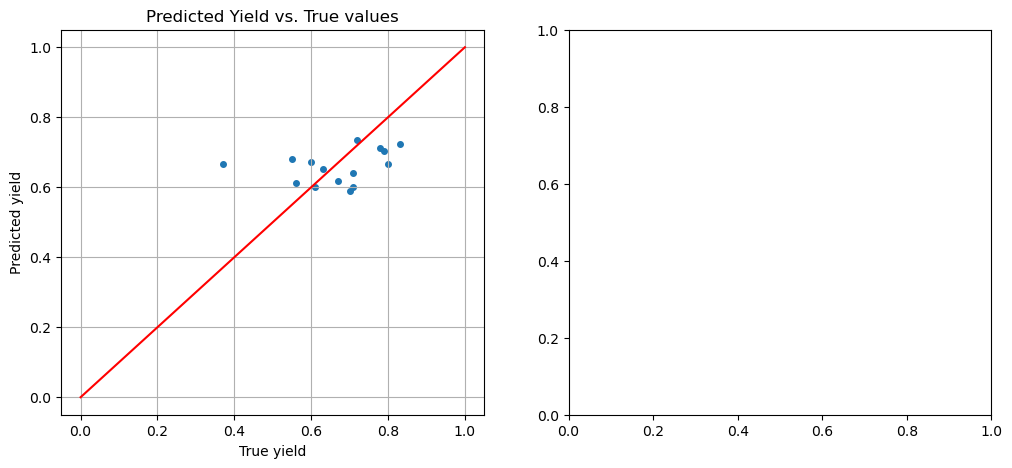

In [9]:
embeddings = get_embedding_from_smi(data_shenvi.smiles.to_list(), data_shenvi.aroma_c_index.to_list(), model_pretrained, device)

np.random.seed(1)
random.seed(1)

n_feat = 5
n_neighbors = 6
w = 'uniform'
dist = 'l1'

y = data_shenvi['label'].values
X = embeddings
loo = LeaveOneOut()
ys_pred = []
ys_true = []

for i, (train_index, test_index) in enumerate(loo.split(X)):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

    mut_info = mutual_info_regression(X_train, y_train)
    X_train = X_train[:, np.argsort(mut_info)[::-1][:n_feat]]
    X_train.reshape(-1, n_feat)
    X_test = X_test[:, np.argsort(mut_info)[::-1][:n_feat]]
    X_test.reshape(-1, n_feat)

    reg = KNeighborsRegressor(n_neighbors=n_neighbors, weights=w, metric=dist)
    # reg = SVR(kernel='linear', C=1e3, gamma=0.1)
    # reg = RandomForestRegressor(max_depth=2, random_state=0, n_estimators=15)
    predictor = make_pipeline(StandardScaler(), TransformedTargetRegressor(regressor=reg, transformer=StandardScaler()))
    predictor.fit(X_train, y_train)
    y_pred = predictor.predict(X_test)
    ys_pred.append(y_pred[0])
    ys_true.append(y_test[0])

print("R2 score: ", r2_score(ys_true, ys_pred))
# plot two subplots
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
ax1.scatter(ys_true, ys_pred, s=16)
ax1.plot([0, 1], [0, 1], c='r')
# ax1.set_xlim(-0.1, 1.1)
# ax1.set_ylim(-0.1, 1.1)
ax1.set_xlabel("True yield")
ax1.set_ylabel("Predicted yield")
ax1.set_title("Predicted Yield vs. True values")
ax1.grid()


plt.show()

In [13]:
np.random.seed(1)
random.seed(1)

n_feat = 7
n_neighbors = 1
w = 'uniform'
dist = 'l1'

y = data_sigman['label'].values

embedding_list = ['scope', 'rdkit2d', 'maccs', 'morgan', 'masking', 'chemgpt']

results = []

for embedding in embedding_list:
    if embedding == 'scope':
        X = get_embedding_from_smi(data_sigman.smiles.to_list(), data_sigman.aroma_c_index.to_list(), model_pretrained, device)
    elif embedding == 'rdkit2d':
        transformer = MolConvert(src = 'SMILES', dst = 'RDKit2D')
        X = transformer(data_sigman.smiles.to_list())
    elif embedding == 'maccs':
        transformer = MolConvert(src = 'SMILES', dst = 'MACCS')
        X = transformer(data_sigman.smiles.to_list())
    elif embedding == 'morgan':
        transformer = MolConvert(src = 'SMILES', dst = 'Morgan')
        X = transformer(data_sigman.smiles.to_list())
    elif embedding == 'masking':
        from molfeat.trans.pretrained import PretrainedDGLTransformer
        transformer = PretrainedDGLTransformer(kind='gin_supervised_masking', dtype=float)
        X = transformer(data_sigman.smiles.to_list())
    elif embedding == 'chemgpt':
        from molfeat.trans.pretrained.hf_transformers import PretrainedHFTransformer
        transformer = PretrainedHFTransformer(kind='ChemGPT-4.7M', notation='selfies', dtype=float)
        X = transformer(data_sigman.smiles.to_list())

    model_list = ['knn', 'linear', 'lasso', 'ridge', 'rf', 'svr']
    r_2s = []

    for model in model_list:

        loo = LeaveOneOut()
        ys_pred = []
        ys_true = []

        for i, (train_index, test_index) in enumerate(loo.split(X)):
            X_train, X_test = X[train_index], X[test_index]
            y_train, y_test = y[train_index], y[test_index]

            mut_info = mutual_info_regression(X_train, y_train)
            X_train = X_train[:, np.argsort(mut_info)[::-1][:n_feat]]
            X_train.reshape(-1, n_feat)
            X_test = X_test[:, np.argsort(mut_info)[::-1][:n_feat]]
            X_test.reshape(-1, n_feat)

            if model == 'linear':
                reg = LinearRegression()
            elif model == 'knn':
                reg = KNeighborsRegressor(n_neighbors=n_neighbors, weights=w, metric=dist)
            elif model == 'lasso':
                reg = Lasso(alpha=0.1)
            elif model == 'ridge':
                reg = Ridge(alpha=.5)
            elif model == 'svr':
                reg = SVR(kernel='rbf', C=1.0, epsilon=0.2)
            elif model == 'rf':
                reg = RandomForestRegressor(max_depth=5, random_state=0, n_estimators=10)
        
            predictor = make_pipeline(StandardScaler(), TransformedTargetRegressor(regressor=reg, transformer=StandardScaler()))
            predictor.fit(X_train, y_train)
            y_pred = predictor.predict(X_test)
            # if y_pred[0] > 1:
            #     y_pred[0] = 1
            # if y_pred[0] < 0:
            #     y_pred[0] = 0
            ys_pred.append(y_pred[0])
            ys_true.append(y_test[0])

        r_2s.append(r2_score(ys_true, ys_pred))
    results.append(r_2s)

results = np.array(results)
results = pd.DataFrame(results, columns=model_list, index=embedding_list)
results

,knn,linear,lasso,ridge,rf,svr
scope,0.522120,-1.378852,-0.161180,-0.085059,-0.027902,0.176039
rdkit2d,0.428051,-242.828776,0.464424,0.260209,0.393908,0.306003
maccs,-1.126285,-0.038836,-0.273056,0.063291,-0.199382,-0.198088
morgan,-0.378719,-0.243932,-0.313293,-0.268526,-0.329484,-0.459740
masking,0.367372,-0.654785,0.261001,0.181042,0.417143,0.371645
chemgpt,0.183140,-19.047328,-0.253636,-0.579164,-0.657283,-0.202741


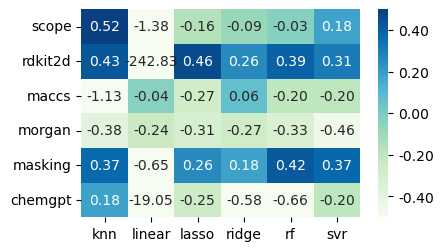

In [17]:

a = 0.45
fig, ax = plt.subplots(figsize=(10*a, 6*a))

sns.heatmap(results, annot=True, fmt='.2f', ax=ax, cmap='GnBu', xticklabels="auto", yticklabels="auto",
            cbar_kws={'shrink': 1.0, 'location': 'right', 'format': "{x:.2f}", 'spacing': 'proportional'}, vmin=-0.5, vmax=0.5)
# set the range of color bar in seaborn


# plt.show()
plt.savefig('hammet_pred_sigman.png', dpi=400, bbox_inches='tight', transparent=True)

In [5]:
# Nickel-catalyzed asymmetric reductive crosscoupling of a-chloroesters with (hetero)aryl iodides

test_delano_smiles = [
    "C1=CC(I)=CN=C1OC",
    "C1C=C(OC)C=C(I)C=1",
    "C1C=C(I)C=CC=1C(=O)C",
    "N1C(F)=CC=C(I)C=1",
    "C(C(F)(F)F)1C=C(I)C=CC=1",
    "C1C2=CC=CC=C2C=C(I)C=1",
    "C1C=C(I)C=CC=1C",
    "C(C)1C=CC=C(I)C=1",
    "C1C=C(I)C=CC=1Cl",
    "N1C(N2CCN(C(=O)OC(C)(C)C)CC2)=CC=C(I)C=1",
    "C1=CC(I)=CC=C1O[Si](C)(C)C(C)(C)C"
]

test_delano_yield = [
    0.77,
    0.89,
    0.68,
    0.74,
    0.61,
    0.94,
    0.86,
    0.86,
    0.79,
    0.64,
    0.79
]

patt_aryl_halide = Chem.MolFromSmarts('c-[I]')
temp = [Chem.MolFromSmiles(smi).GetSubstructMatch(patt_aryl_halide) for smi in test_delano_smiles]

data_delano = pd.DataFrame({
    "smiles": test_delano_smiles,
    "label": test_delano_yield,
    "aroma_c_index": [_[0] for _ in temp],
    "halide_index": [_[1] for _ in temp]
})

embeddings = get_embedding_from_smi(data_delano.smiles.to_list(), data_delano.aroma_c_index.to_list(), model_pretrained, device)

In [6]:
embeddings = get_embedding_from_smi(data_delano.smiles.to_list(), data_delano.aroma_c_index.to_list(), model_pretrained, device)
highest = 0

for n_feat in range(1, 9):
    for n_neighbors in range(1, 9):
        for w in ['uniform', 'distance']:
            for dist in ['l1', 'l2', 'cosine']:

                y = data_delano['label'].values
                X = embeddings
                loo = LeaveOneOut()
                ys_pred = []
                ys_true = []

                np.random.seed(0)
                random.seed(0)

                for i, (train_index, test_index) in enumerate(loo.split(X)):
                    X_train, X_test = X[train_index], X[test_index]
                    y_train, y_test = y[train_index], y[test_index]

                    mut_info = mutual_info_regression(X_train, y_train)
                    X_train = X_train[:, np.argsort(mut_info)[::-1][:n_feat]]
                    X_train.reshape(-1, n_feat)
                    X_test = X_test[:, np.argsort(mut_info)[::-1][:n_feat]]
                    X_test.reshape(-1, n_feat)

                    reg = KNeighborsRegressor(n_neighbors=n_neighbors, weights=w, metric=dist)
                    # reg = SVR(kernel='rbf', C=1e3, gamma=0.1)
                    # reg = RandomForestRegressor(max_depth=5, random_state=0, n_estimators=5)
                    predictor = make_pipeline(StandardScaler(), TransformedTargetRegressor(regressor=reg, transformer=StandardScaler()))
                    predictor.fit(X_train, y_train)
                    y_pred = predictor.predict(X_test)
                    ys_pred.append(y_pred[0])
                    ys_true.append(y_test[0])

                print(f"# features; {n_feat:2d}, # neighbors: {n_neighbors:2d}, type: {w}, distance: {dist}, R2: {r2_score(ys_true, ys_pred):.3f}")
                if r2_score(ys_true, ys_pred) > highest:
                    highest = r2_score(ys_true, ys_pred)
                    best_params = {
                        "n_feat": n_feat,
                        "n_neighbors": n_neighbors,
                        "w": w,
                        "dist": dist,
                        "r2": highest
                    }
print(best_params)

# features;  1, # neighbors:  1, type: uniform, distance: l1, R2: -0.258
# features;  1, # neighbors:  1, type: uniform, distance: l2, R2: -0.258
# features;  1, # neighbors:  1, type: uniform, distance: cosine, R2: -0.381
# features;  1, # neighbors:  1, type: distance, distance: l1, R2: -0.258
# features;  1, # neighbors:  1, type: distance, distance: l2, R2: -0.258
# features;  1, # neighbors:  1, type: distance, distance: cosine, R2: -0.381
# features;  1, # neighbors:  2, type: uniform, distance: l1, R2: -0.537
# features;  1, # neighbors:  2, type: uniform, distance: l2, R2: -0.537
# features;  1, # neighbors:  2, type: uniform, distance: cosine, R2: -0.168
# features;  1, # neighbors:  2, type: distance, distance: l1, R2: -0.311
# features;  1, # neighbors:  2, type: distance, distance: l2, R2: -0.311
# features;  1, # neighbors:  2, type: distance, distance: cosine, R2: -0.168
# features;  1, # neighbors:  3, type: uniform, distance: l1, R2: -0.043
# features;  1, # neighbors: 

In [13]:
# Nickel-Catalyzed Asymmetric Reductive Cross-Coupling between Heteroaryl Iodides and α-Chloronitriles

test_kadunce_smiles = [
    "C1C=C(I)C=NC=1Cl",
    "C1C(Br)=NC=C(I)C=1",
    "C1C=C(I)C=NC=1C(F)(F)F",
    "C1C(OC)=NC=C(I)C=1",
    "C1C=C(I)C=NC=1F",
    "C(F)1C=C(I)C=CN=1",
    "C1C=NC(F)=C(I)C=1",
    "N1C(Cl)=NC=C(I)C=1",
    "N1C=C(I)C=NC=1OC",
    "N1C(SC2=CC=CC=C2)=NC=C(I)C=1",
    "N1C=C(I)C=NC=1N1CCCCC1",
    "N1C(N2CCCC2)=NC=C(I)C=1",
    "N1C=C(I)C=NC=1N1CCN(C(OC(C)(C)C)=O)CC1",
    "IC1SC=CC=1",
    "C12=NC(C3=CC=C(Br)C=C3)=CN1C=CC(=C2)I"
]

test_kadunce_yield = [
    0.82,
    0.68,
    0.70,
    0.45,
    0.64,
    0.60,
    0.37,
    0.41,
    0.71,
    0.76,
    0.70,
    0.60,
    0.69,
    0.87,
    0.72
]

patt_aryl_halide = Chem.MolFromSmarts('c-[I]')
temp = [Chem.MolFromSmiles(smi).GetSubstructMatch(patt_aryl_halide) for smi in test_kadunce_smiles]

# for smi in test_kadunce_smiles:
#     print(smi)
#     print(Chem.MolFromSmiles(smi).GetSubstructMatch(patt_aryl_halide))
#     print()

data_kadunce = pd.DataFrame({
    "smiles": test_kadunce_smiles,
    "label": test_kadunce_yield,
    "aroma_c_index": [_[0] for _ in temp],
    "halide_index": [_[1] for _ in temp]
})

embeddings = get_embedding_from_smi(data_kadunce.smiles.to_list(), data_kadunce.aroma_c_index.to_list(), model_pretrained, device)

In [14]:
embeddings = get_embedding_from_smi(data_kadunce.smiles.to_list(), data_kadunce.aroma_c_index.to_list(), model_pretrained, device)
highest = 0

for n_feat in range(1, 9):
    for n_neighbors in range(1, 9):
        for w in ['uniform', 'distance']:
            for dist in ['l1', 'l2', 'cosine']:

                y = data_kadunce['label'].values
                X = embeddings
                loo = LeaveOneOut()
                ys_pred = []
                ys_true = []

                np.random.seed(0)
                random.seed(0)

                for i, (train_index, test_index) in enumerate(loo.split(X)):
                    X_train, X_test = X[train_index], X[test_index]
                    y_train, y_test = y[train_index], y[test_index]

                    mut_info = mutual_info_regression(X_train, y_train)
                    X_train = X_train[:, np.argsort(mut_info)[::-1][:n_feat]]
                    X_train.reshape(-1, n_feat)
                    X_test = X_test[:, np.argsort(mut_info)[::-1][:n_feat]]
                    X_test.reshape(-1, n_feat)

                    reg = KNeighborsRegressor(n_neighbors=n_neighbors, weights=w, metric=dist)
                    # reg = SVR(kernel='rbf', C=1e3, gamma=0.1)
                    # reg = RandomForestRegressor(max_depth=5, random_state=0, n_estimators=5)
                    predictor = make_pipeline(StandardScaler(), TransformedTargetRegressor(regressor=reg, transformer=StandardScaler()))
                    predictor.fit(X_train, y_train)
                    y_pred = predictor.predict(X_test)
                    ys_pred.append(y_pred[0])
                    ys_true.append(y_test[0])

                print(f"# features; {n_feat:2d}, # neighbors: {n_neighbors:2d}, type: {w}, distance: {dist}, R2: {r2_score(ys_true, ys_pred):.3f}")
                if r2_score(ys_true, ys_pred) > highest:
                    highest = r2_score(ys_true, ys_pred)
                    best_params = {
                        "n_feat": n_feat,
                        "n_neighbors": n_neighbors,
                        "w": w,
                        "dist": dist,
                        "r2": highest
                    }
print(best_params)

# features;  1, # neighbors:  1, type: uniform, distance: l1, R2: -1.298
# features;  1, # neighbors:  1, type: uniform, distance: l2, R2: -1.298
# features;  1, # neighbors:  1, type: uniform, distance: cosine, R2: -1.405
# features;  1, # neighbors:  1, type: distance, distance: l1, R2: -1.298
# features;  1, # neighbors:  1, type: distance, distance: l2, R2: -1.298
# features;  1, # neighbors:  1, type: distance, distance: cosine, R2: -1.405
# features;  1, # neighbors:  2, type: uniform, distance: l1, R2: -0.532
# features;  1, # neighbors:  2, type: uniform, distance: l2, R2: -0.532
# features;  1, # neighbors:  2, type: uniform, distance: cosine, R2: -0.771
# features;  1, # neighbors:  2, type: distance, distance: l1, R2: -0.607
# features;  1, # neighbors:  2, type: distance, distance: l2, R2: -0.607
# features;  1, # neighbors:  2, type: distance, distance: cosine, R2: -0.771
# features;  1, # neighbors:  3, type: uniform, distance: l1, R2: -0.321
# features;  1, # neighbors: 

In [20]:
# np.random.seed(0)
# random.seed(0)

n_feat = 3
n_neighbors = 6
w = 'uniform'
dist = 'l2'

y = data_kadunce['label'].values

embedding_list = ['scope', 'rdkit2d', 'maccs', 'morgan', 'masking', 'chemgpt']

results = []

for embedding in embedding_list:
    if embedding == 'scope':
        X = get_embedding_from_smi(data_kadunce.smiles.to_list(), data_kadunce.aroma_c_index.to_list(), model_pretrained, device)
    elif embedding == 'rdkit2d':
        transformer = MolConvert(src = 'SMILES', dst = 'RDKit2D')
        X = transformer(data_kadunce.smiles.to_list())
    elif embedding == 'maccs':
        transformer = MolConvert(src = 'SMILES', dst = 'MACCS')
        X = transformer(data_kadunce.smiles.to_list())
    elif embedding == 'morgan':
        transformer = MolConvert(src = 'SMILES', dst = 'Morgan')
        X = transformer(data_kadunce.smiles.to_list())
    elif embedding == 'masking':
        from molfeat.trans.pretrained import PretrainedDGLTransformer
        transformer = PretrainedDGLTransformer(kind='gin_supervised_masking', dtype=float)
        X = transformer(data_kadunce.smiles.to_list())
    elif embedding == 'chemgpt':
        from molfeat.trans.pretrained.hf_transformers import PretrainedHFTransformer
        transformer = PretrainedHFTransformer(kind='ChemGPT-4.7M', notation='selfies', dtype=float)
        X = transformer(data_kadunce.smiles.to_list())

    model_list = ['knn', 'linear', 'lasso', 'ridge', 'rf', 'svr']
    r_2s = []

    for model in model_list:

        loo = LeaveOneOut()
        ys_pred = []
        ys_true = []

        np.random.seed(0)
        random.seed(0)

        for i, (train_index, test_index) in enumerate(loo.split(X)):
            X_train, X_test = X[train_index], X[test_index]
            y_train, y_test = y[train_index], y[test_index]

            mut_info = mutual_info_regression(X_train, y_train)
            X_train = X_train[:, np.argsort(mut_info)[::-1][:n_feat]]
            X_train.reshape(-1, n_feat)
            X_test = X_test[:, np.argsort(mut_info)[::-1][:n_feat]]
            X_test.reshape(-1, n_feat)

            if model == 'linear':
                reg = LinearRegression()
            elif model == 'knn':
                reg = KNeighborsRegressor(n_neighbors=n_neighbors, weights=w, metric=dist)
            elif model == 'lasso':
                reg = Lasso(alpha=0.1)
            elif model == 'ridge':
                reg = Ridge(alpha=.5)
            elif model == 'svr':
                reg = SVR(kernel='rbf', C=1.0, epsilon=0.2)
            elif model == 'rf':
                reg = RandomForestRegressor(max_depth=5, random_state=0, n_estimators=10)
        
            predictor = make_pipeline(StandardScaler(), TransformedTargetRegressor(regressor=reg, transformer=StandardScaler()))
            predictor.fit(X_train, y_train)
            y_pred = predictor.predict(X_test)
            # if y_pred[0] > 1:
            #     y_pred[0] = 1
            # if y_pred[0] < 0:
            #     y_pred[0] = 0
            ys_pred.append(y_pred[0])
            ys_true.append(y_test[0])

        r_2s.append(r2_score(ys_true, ys_pred))
    results.append(r_2s)

results = np.array(results)
results = pd.DataFrame(results, columns=model_list, index=embedding_list)
results

,knn,linear,lasso,ridge,rf,svr
scope,-0.315304,-2.351454,-1.174644,-1.962421,-0.476579,-0.879960
rdkit2d,0.192113,0.084754,0.105096,0.082135,0.044227,0.155996
maccs,-0.275204,-0.232605,-0.154269,-0.227810,-0.216981,-0.070947
morgan,-0.432373,-0.958060,-0.502104,-0.750941,-0.348209,-0.380406
masking,-0.423936,-0.968154,-0.526438,-0.877371,-1.388559,-0.533727
chemgpt,-0.407615,-1.488045,-0.666374,-1.184549,-0.840966,-0.622896


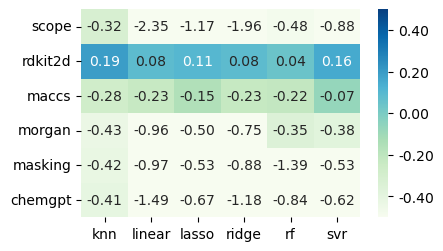

In [21]:
a = 0.45
fig, ax = plt.subplots(figsize=(10*a, 6*a))

sns.heatmap(results, annot=True, fmt='.2f', ax=ax, cmap='GnBu', xticklabels="auto", yticklabels="auto",
            cbar_kws={'shrink': 1.0, 'location': 'right', 'format': "{x:.2f}", 'spacing': 'proportional'}, vmin=-0.5, vmax=0.5)
# set the range of color bar in seaborn


plt.show()
# plt.savefig('hammet_pred_sigman.png', dpi=400, bbox_inches='tight', transparent=True)

In [1]:
# Palladium-Catalyzed C−F Activation of Polyfluoronitrobenzene Derivatives in Suzuki−Miyaura Coupling Reactions

smiles_list = [
    "C(N(=O)=O)1=C(F)C(F)=C(F)C(F)=C1F",
    "C(N(=O)=O)1=C(F)C(F)=C(F)C(F)=C1F",
    "C(N(=O)=O)1=C(F)C(F)=C(F)C(F)=C1F",
    "C1(C(F)=CC(F)=C(F)C=1F)[N+]([O-])=O",
    "C1(C(F)=CC(F)=C(F)C=1F)[N+]([O-])=O",
    "C1(C(F)=CC(F)=C(F)C=1F)[N+]([O-])=O",
    "C1(C(F)=CC(F)=C(F)C=1F)[N+]([O-])=O",
    "C1(C(F)=C(F)C(F)=C(F)C=1)[N+](=O)[O-]",
    "C1(C(F)=C(F)C(F)=C(F)C=1)[N+](=O)[O-]",
    "C1(C(F)=C(F)C(F)=C(F)C=1)[N+](=O)[O-]",
    "C1(C(F)=C(F)C(F)=C(F)C=1)[N+](=O)[O-]",
    "C1(C(F)=C(F)C=C(F)C=1F)[N+]([O-])=O",
    "C1(C(F)=C(F)C=C(F)C=1F)[N+]([O-])=O",
    "C1(C=CC(F)=C(F)C=1F)[N+](=O)[O-]",
    "C1(C=CC(F)=C(F)C=1F)[N+](=O)[O-]",
    "C1(C=CC(F)=C(F)C=1F)[N+](=O)[O-]",
    "C1(C(F)=CC(F)=CC=1F)[N+]([O-])=O",
    "C1(C(F)=CC(F)=CC=1F)[N+]([O-])=O",
    "C1(C(F)=CC(F)=C(F)C=1)[N+](=O)[O-]",
    "C1(C(F)=CC(F)=C(F)C=1)[N+](=O)[O-]",
    "C1(C(F)=CC(F)=C(F)C=1)[N+](=O)[O-]",
]

c_index_list = [
    4,
    6,
    8,
    1,
    4,
    6,
    8,
    1,
    3,
    5,
    7,
    1,
    3,
    3,
    5,
    7,
    1,
    4,
    1,
    4,
    6,
]

yield_list = [
    0.84,
    0.00,
    0.00,
    0.00,
    0.00,
    0.00,
    0.54,
    0.27,
    0.00,
    0.00,
    0.00,
    0.48,
    0.00,
    0.00,
    0.00,
    0.50,
    0.54,
    0.00,
    0.34,
    0.00,
    0.00,
]

site_list = [
    1,
    0,
    0,
    0,
    0,
    0,
    1,
    1,
    0,
    0,
    0,
    1,
    0,
    0,
    0,
    1,
    1,
    0,
    1,
    0,
    0,
]

In [2]:
s = "C1(C(F)=CC(F)=C(F)C=1)[N+](=O)[O-]"
patt_aryl_halide = Chem.MolFromSmarts('c-[F]')
Chem.MolFromSmiles(s).GetSubstructMatches(patt_aryl_halide)

NameError: name 'Chem' is not defined

In [7]:
embeddings = get_embedding_from_smi(smiles_list, c_index_list, model_pretrained, device)

[0.2385593  0.         0.         0.24999582 0.15921351 0.
 0.         0.01272497 0.26131558 0.        ]
[0.   0.   0.   0.54 0.27 0.   0.   0.   0.48 0.  ]
0.5302774606333374


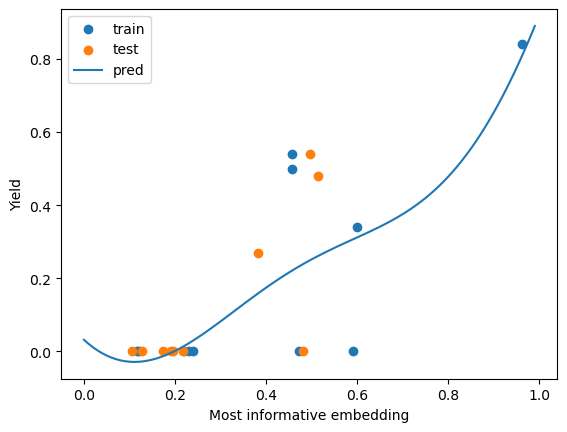

In [9]:
np.random.seed(0)
random.seed(0)

from sklearn import linear_model

X_train = np.concatenate([embeddings[:3],embeddings[13:]], axis=0)
y_train = np.array(yield_list[:3] + yield_list[13:])

X_test = embeddings[3:13]
y_test = np.array(yield_list[3:13])

mut_info = mutual_info_regression(X_train, y_train)
X_train = X_train[:, [np.argsort(mut_info)[::-1][1]]]
# X_train = X_train[:, [np.argsort(mut_info)[::-1][1], np.argsort(mut_info)[::-1][2]]]
X_train = X_train.reshape(-1, 1)
X_test = X_test[:, [np.argsort(mut_info)[::-1][1]]]
# X_test = X_test[:, [np.argsort(mut_info)[::-1][1], np.argsort(mut_info)[::-1][2]]]
X_test = X_test.reshape(-1, 1)

# reg = KNeighborsRegressor(n_neighbors=1, weights='distance', metric='l2')
reg = SVR(kernel='rbf', C=1e3, gamma=0.1, degree=3)
# reg = RandomForestRegressor(max_depth=4, random_state=0, n_estimators=3)
# reg = LinearRegression()
# reg = Ridge(alpha=.5)
# reg = Lasso(alpha=0.1)
# reg = linear_model.TweedieRegressor(power=2, alpha=0.5)
predictor = make_pipeline(StandardScaler(), TransformedTargetRegressor(regressor=reg, transformer=StandardScaler()))
predictor.fit(X_train, y_train)
y_pred = predictor.predict(X_test)
for i, y in enumerate(y_pred):
    if y > 1:
        y_pred[i] = 1
    if y < 0:
        y_pred[i] = 0

print(y_pred)
print(y_test)
print(r2_score(y_test, y_pred))

X_exam = np.arange(0, 1.0, 0.01)
y_exam = predictor.predict(X_exam.reshape(-1, 1))

plt.scatter(X_train[:, 0], y_train, label='train')
plt.scatter(X_test[:, 0], y_test, label='test')
plt.plot(X_exam, y_exam, label='pred')
plt.xlabel('Most informative embedding')
plt.ylabel('Yield')
plt.legend()
plt.show()

In [11]:
y_pred[:4]

array([0.2385593 , 0.        , 0.        , 0.24999582])

In [12]:
import numpy as np

def softmax(x):
    """Compute softmax values for each sets of scores in x."""
    e_x = np.exp(x - np.max(x))
    return e_x / e_x.sum()

softmax(y_pred[:4])

array([0.27878247, 0.21961423, 0.21961423, 0.28198907])

In [8]:
mut_info

array([0.        , 0.        , 0.14209957, 0.        , 0.27106782,
       0.20678211, 0.23217893, 0.17720058, 0.24859307, 0.        ,
       0.02593795, 0.        , 0.07301587, 0.        , 0.1461039 ,
       0.18257576, 0.        , 0.        , 0.        , 0.12059885,
       0.10191198, 0.12842713, 0.        , 0.        , 0.        ,
       0.09747475, 0.01529582, 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.00205628, 0.02579365,
       0.        , 0.        , 0.        , 0.        , 0.01515152,
       0.01800144, 0.02777778, 0.        , 0.        , 0.        ,
       0.        , 0.04292929, 0.        , 0.07813853, 0.        ,
       0.        , 0.17564935, 0.04220779, 0.02867965, 0.        ,
       0.        , 0.05198413, 0.        , 0.        , 0.05862193,
       0.        , 0.        , 0.        , 0.0700938 ])

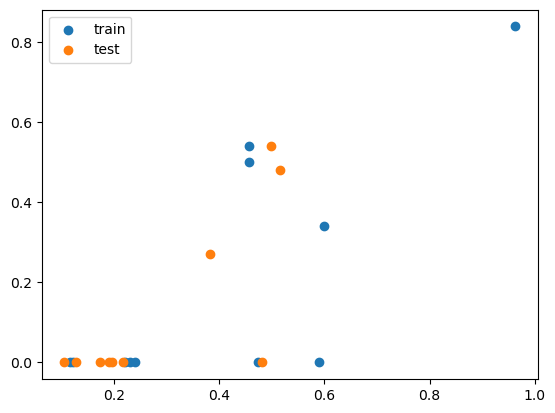

In [9]:
np.random.seed(0)
random.seed(0)

X_train = np.concatenate([embeddings[:3],embeddings[13:]], axis=0)
y_train = np.array(yield_list[:3] + yield_list[13:])

X_test = embeddings[3:13]
y_test = np.array(yield_list[3:13])

mut_info = mutual_info_regression(X_train, y_train)
X_train = X_train[:, [np.argsort(mut_info)[::-1][:5]]]
# X_train = X_train[:, [np.argsort(mut_info)[::-1][0], np.argsort(mut_info)[::-1][5]]]
X_train = X_train.reshape(-1, 5)
X_test = X_test[:, [np.argsort(mut_info)[::-1][:5]]]
# X_test = X_test[:, [np.argsort(mut_info)[::-1][0], np.argsort(mut_info)[::-1][5]]]
X_test = X_test.reshape(-1, 5)

plt.scatter(X_train[:, 1], y_train, label='train')
plt.scatter(X_test[:, 1], y_test, label='test')
plt.legend()
plt.show()

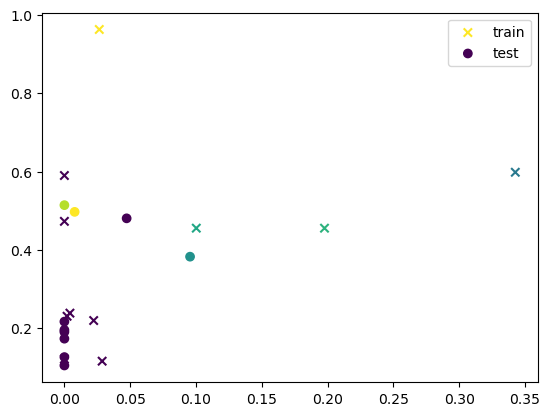

In [10]:
plt.scatter(X_train[:, 0], X_train[:, 1], c=y_train, label='train', marker='x')
plt.scatter(X_test[:, 0], X_test[:, 1], c=y_test, label='test', marker='o')
plt.legend()
plt.show()

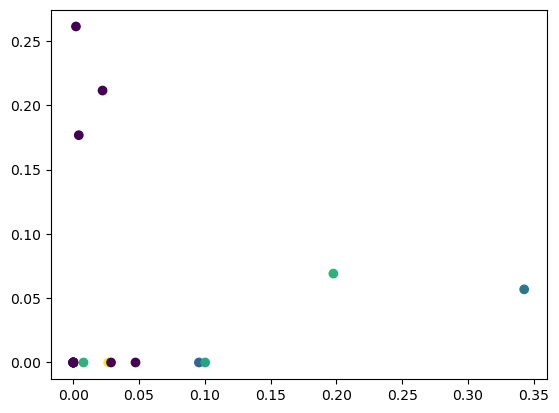

In [11]:
plt.scatter(embeddings[:, np.argsort(mut_info)[::-1][0]], embeddings[:, np.argsort(mut_info)[::-1][5]], c=yield_list)
plt.show()

In [39]:
np.random.seed(0)
random.seed(0)

from sklearn import linear_model
from sklearn import metrics

X_train = np.concatenate([embeddings[:3],embeddings[11:]], axis=0)
y_train = np.array(site_list[:3] + site_list[11:])

X_test = embeddings[3:11]
y_test = np.array(site_list[3:11])

mut_info = mutual_info_regression(X_train, y_train)
X_train = X_train[:, [np.argsort(mut_info)[::-1][:3]]]
# X_train = X_train[:, [np.argsort(mut_info)[::-1][1], np.argsort(mut_info)[::-1][2]]]
X_train = X_train.reshape(-1, 3)
X_test = X_test[:, [np.argsort(mut_info)[::-1][:3]]]
# X_test = X_test[:, [np.argsort(mut_info)[::-1][1], np.argsort(mut_info)[::-1][2]]]
X_test = X_test.reshape(-1, 3)

# cla = KNeighborsClassifier(n_neighbors=1, weights='distance', metric='l2')
cla = SVC(kernel='sigmoid', C=1e3, gamma='scale', degree=8, probability=True)
predictor = make_pipeline(StandardScaler(), cla)
predictor.fit(X_train, y_train)
y_pred = predictor.predict(X_test)
y_pred_proba = predictor.predict_proba(X_test)

print(y_pred)
print(y_pred_proba)
print(y_test)
print(metrics.accuracy_score(y_test, y_pred))

# X_exam = np.arange(0, 1.0, 0.01)
# y_exam = predictor.predict(X_exam.reshape(-1, 1))

# plt.scatter(X_train[:, 0], y_train, label='train')
# plt.scatter(X_test[:, 0], y_test, label='test')
# plt.plot(X_exam, y_exam, label='pred')
# plt.legend()
# plt.show()

[1 0 0 1 1 0 0 0]
[[0.55885489 0.44114511]
 [0.63221104 0.36778896]
 [0.65969119 0.34030881]
 [0.57992562 0.42007438]
 [0.55819196 0.44180804]
 [0.69406577 0.30593423]
 [0.67141136 0.32858864]
 [0.615497   0.384503  ]]
[0 0 0 1 1 0 0 0]
0.875


In [77]:
[np.argsort(mut_info)[::-1][0], np.argsort(mut_info)[::-1][5]]

[8, 51]

In [109]:
X_train.reshape(-1, 1)
X_train.shape

(11, 64)

In [4]:
# Reactivity and regioselectivity in Stille couplings of 3-substituted 2,4-dichloropyridines

smiles_list = [
    "C(Cl)1=CC=NC(Cl)=C1",
    "C(Cl)1=CC=NC(Cl)=C1",
    "C1(C(N)=C(Cl)N=CC=1)Cl",
    "C1(C(N)=C(Cl)N=CC=1)Cl",
    "C1(C=CN=C(Cl)C=1C(N)=O)Cl",
    "C1(C=CN=C(Cl)C=1C(N)=O)Cl",
    "C1(C(C=O)=C(Cl)N=CC=1)Cl",
    "C1(C(C=O)=C(Cl)N=CC=1)Cl",
    "C1(C=CN=C(Cl)C=1C(OC)=O)Cl",
    "C1(C=CN=C(Cl)C=1C(OC)=O)Cl",
    "C1(C(C#N)=C(Cl)N=CC=1)Cl",
    "C1(C(C#N)=C(Cl)N=CC=1)Cl",
    "C1(C=CN=C(Cl)C=1N(=O)=O)Cl",
    "C1(C=CN=C(Cl)C=1N(=O)=O)Cl",
    "C1(C([N+](=O)[O-])=C(Cl)N=C(Cl)C=1)Cl",
    "C1(C([N+](=O)[O-])=C(Cl)N=C(Cl)C=1)Cl",
    "C1(C([N+](=O)[O-])=C(Cl)N=C(Cl)C=1)Cl",
]

c_index_list = [
    5,
    0,
    3,
    0,
    4,
    0,
    4,
    0,
    4,
    0,
    4,
    0,
    4,
    0,
    5,
    0,
    8,
]

yield_list = [
    0.37,
    0.00,
    1.00,
    0.00,
    0.13,
    0.00,
    0.65,
    0.11,
    0.54,
    0.00,
    0.82,
    0.13,
    0.13,
    0.76,
    0.02,
    0.87,
    0.00,
]

site_list = [
    1,
    0,
    1,
    0,
    1,
    0,
    1,
    0,
    1,
    0,
    1,
    0,
    0,
    1,
    0,
    1,
    0,
]


In [47]:
s = "C1(C([N+](=O)[O-])=C(Cl)N=C(Cl)C=1)Cl"
patt_aryl_halide = Chem.MolFromSmarts('c-[Cl]')
Chem.MolFromSmiles(s).GetSubstructMatches(patt_aryl_halide)

((0, 11), (5, 6), (8, 9))

In [7]:
embeddings = get_embedding_from_smi(smiles_list, c_index_list, model_pretrained, device)

[0.37747272 0.1179663  0.05613829 0.24953061]
[1.   0.   0.13 0.76]
0.04844674732439369


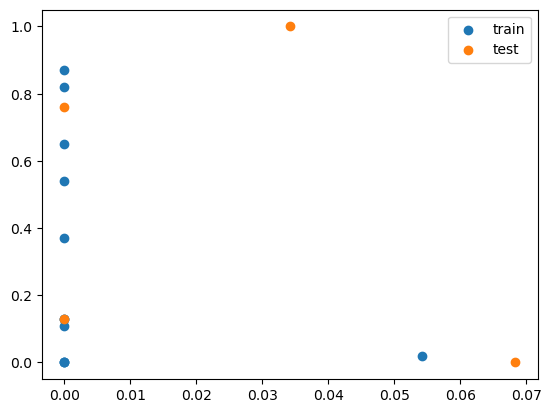

In [53]:
np.random.seed(1)
random.seed(1)

from sklearn import linear_model

train_list = [0, 1, 4, 5, 6, 7, 8, 9, 10, 11, 14, 15]
test_list = [2, 3, 12, 13]

X_train = embeddings[train_list, :]
y_train = np.array(yield_list)[train_list]

X_test = embeddings[test_list, :]
y_test = np.array(yield_list)[test_list]

# n_feat = 3

# mut_info = mutual_info_regression(X_train, y_train)
# X_train = X_train[:, [np.argsort(mut_info)[::-1][:n_feat]]]
# # X_train = X_train[:, [np.argsort(mut_info)[::-1][1], np.argsort(mut_info)[::-1][2]]]
# X_train = X_train.reshape(-1, n_feat)
# X_test = X_test[:, [np.argsort(mut_info)[::-1][:n_feat]]]
# # X_test = X_test[:, [np.argsort(mut_info)[::-1][1], np.argsort(mut_info)[::-1][2]]]
# X_test = X_test.reshape(-1, n_feat)

reg = KNeighborsRegressor(n_neighbors=3, weights='distance', metric='cosine')
# reg = SVR(kernel='rbf', C=1e3, gamma="scale", degree=3)
# reg = RandomForestRegressor(max_depth=4, random_state=0, n_estimators=3)
# reg = LinearRegression()
# reg = Ridge(alpha=.5)
# reg = Lasso(alpha=0.1)
# reg = linear_model.TweedieRegressor(power=2, alpha=0.5)
predictor = make_pipeline(StandardScaler(), TransformedTargetRegressor(regressor=reg, transformer=StandardScaler()))
predictor.fit(X_train, y_train)
y_pred = predictor.predict(X_test)
for i, y in enumerate(y_pred):
    if y > 1:
        y_pred[i] = 1
    if y < 0:
        y_pred[i] = 0

print(y_pred)
print(y_test)
print(r2_score(y_test, y_pred))

# X_exam = np.arange(0, 1.0, 0.01)
# y_exam = predictor.predict(X_exam.reshape(-1, 1))

plt.scatter(X_train[:, 0], y_train, label='train')
plt.scatter(X_test[:, 0], y_test, label='test')
# plt.plot(X_exam, y_exam, label='pred')
plt.legend()
plt.show()

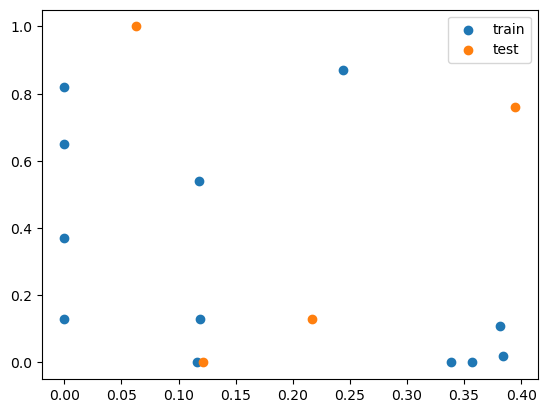

In [46]:
np.random.seed(0)
random.seed(0)

train_list = [0, 1, 4, 5, 6, 7, 8, 9, 10, 11, 14, 15]
test_list = [2, 3, 12, 13]

X_train = embeddings[train_list, :]
y_train = np.array(yield_list)[train_list]

X_test = embeddings[test_list, :]
y_test = np.array(yield_list)[test_list]

n_feat = 10

mut_info = mutual_info_regression(X_train, y_train)
X_train = X_train[:, [np.argsort(mut_info)[::-1][:n_feat]]]
# X_train = X_train[:, [np.argsort(mut_info)[::-1][1], np.argsort(mut_info)[::-1][2]]]
X_train = X_train.reshape(-1, n_feat)
X_test = X_test[:, [np.argsort(mut_info)[::-1][:n_feat]]]
# X_test = X_test[:, [np.argsort(mut_info)[::-1][1], np.argsort(mut_info)[::-1][2]]]
X_test = X_test.reshape(-1, n_feat)

show_ind = 0

plt.scatter(X_train[:, show_ind], y_train, label='train')
plt.scatter(X_test[:, show_ind], y_test, label='test')
plt.legend()
plt.show()

In [44]:
np.random.seed(0)
random.seed(0)

train_list = [0, 1, 4, 5, 6, 7, 8, 9, 10, 11, 14, 15]
test_list = [2, 3, 12, 13]

X_train = embeddings[train_list, :]
y_train = np.array(yield_list)[train_list]

X_test = embeddings[test_list, :]
y_test = np.array(yield_list)[test_list]

mut_info = mutual_info_regression(X_train, y_train)

mut_info[np.argsort(mut_info)]

array([0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 6.66133815e-16,
       6.66133815e-16, 6.66133815e-16, 5.29401154e-03, 8.45959596e-03,
       1.47516835e-02, 1.74302549e-02, 1.89183502e-02, 2.10648148e-02,
       3.05555556e-02, 3.77314815e-02, 4.55387205e-02, 5.22516835e-02,
       5.23839586e-02, 5.92261905e-02, 6.92490380e-02, 8.18813131e-02,
       8.35678211e-02, 8.58164983e-02, 8.92887205e-02, 9.33561809e-02,
      

# Informers

In [4]:
data_buyable = pd.read_csv("../data/buyable_aryl_bromides.csv")
embedding_buyable = get_embedding_from_smi(
    data_buyable.smiles.to_list(),
    data_buyable.c_index.to_list(),
    model_pretrained,
    device
)

In [5]:
embedding_informer = embedding_buyable[data_buyable['informer']]

In [6]:
embedding_informer

array([[0.21771209, 0.13717285, 0.16614988, ..., 0.0326742 , 0.11939248,
        0.        ],
       [0.07822677, 0.        , 0.17416647, ..., 0.12911287, 0.19279607,
        0.        ],
       [0.06281342, 0.        , 0.1714052 , ..., 0.        , 0.08641268,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 0.        , 0.14885576,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.00644155,
        0.        ]], dtype=float32)

In [7]:
data_yield = pd.DataFrame({
    'X1': [0, 1],
    'X2': [2, 3]
})

In [8]:
data_yield.to_csv('informer_yields.csv', index=False)

In [9]:
data_yield = pd.read_csv("informer_yields.csv")

In [10]:
yield_informer = data_yield.T.to_numpy() / 100

In [11]:
yield_informer.shape

(2, 2)

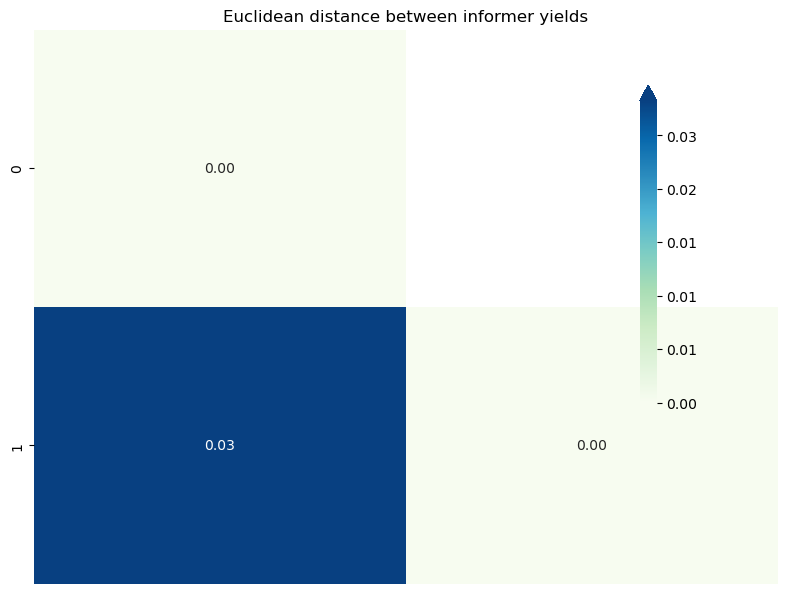

In [12]:
dist_mat_yield = sklearn.metrics.pairwise_distances(yield_informer, metric="euclidean")
a = 1.2
fig, ax = plt.subplots(figsize=(10*a, 6*a))
matrix = np.triu(np.ones_like(dist_mat_yield, dtype=bool))
np.fill_diagonal(matrix, False)
sns.heatmap(dist_mat_yield, annot=True, mask=matrix, fmt='.2f', ax=ax, cmap='GnBu', xticklabels=False, yticklabels="auto",
            cbar_kws={'shrink': 0.6, 'location': 'right', 'anchor': (-1.5, 0.75), 'format': "{x:.2f}", 'spacing': 'proportional', 'extend': 'both'})
# set the range of color bar in seaborn
plt.title("Euclidean distance between informer yields")
plt.show()

In [13]:
def snr_distance(ri, rj):
    return 2*np.var(ri - rj) / (np.var(ri) + np.var(rj))

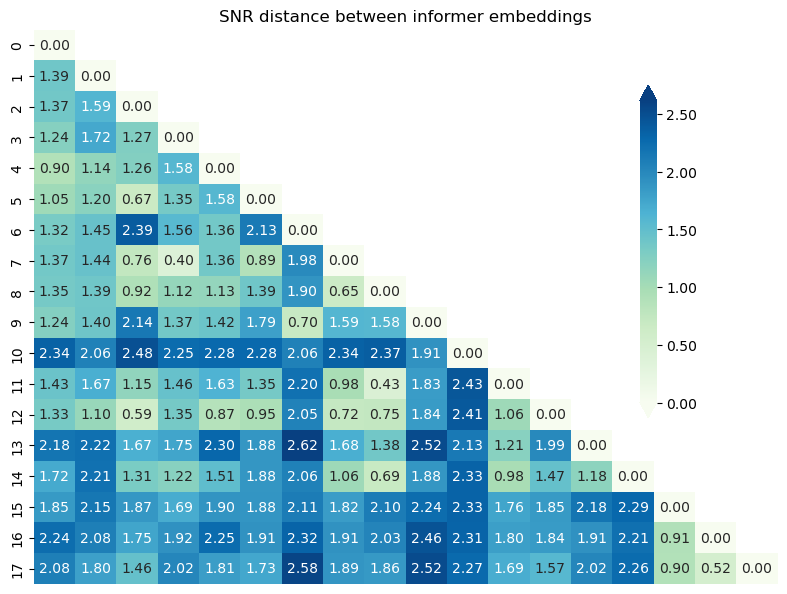

In [15]:
dist_mat_yield = sklearn.metrics.pairwise_distances(embedding_informer, metric=snr_distance)
a = 1.2
fig, ax = plt.subplots(figsize=(10*a, 6*a))
matrix = np.triu(np.ones_like(dist_mat_yield, dtype=bool))
np.fill_diagonal(matrix, False)
sns.heatmap(dist_mat_yield, annot=True, mask=matrix, fmt='.2f', ax=ax, cmap='GnBu', xticklabels=False, yticklabels="auto",
            cbar_kws={'shrink': 0.6, 'location': 'right', 'anchor': (-1.5, 0.75), 'format': "{x:.2f}", 'spacing': 'proportional', 'extend': 'both'})
# sns.heatmap(dist_mat_yield, annot=True, mask=matrix, fmt='.2f', ax=ax, cmap='GnBu', xticklabels=False, yticklabels="auto",
#             cbar_kws={'shrink': 0.6, 'location': 'right', 'anchor': (-1.5, 0.75), 'format': "{x:.2f}", 'spacing': 'proportional', 'extend': 'both'}, vmin=0, vmax=7)
# set the range of color bar in seaborn
plt.title("SNR distance between informer embeddings")
# plt.show()
plt.savefig('snr_distance_informer.png', dpi=500, bbox_inches='tight', transparent=True)

# Buyable

In [5]:
data_buyable = pd.read_csv("../data/buyable_aryl_bromides.csv")
data_buyable = data_buyable[data_buyable['informer'] == False]

In [9]:
embeddings = get_embedding_from_smi(data_buyable.smiles.to_list(), data_buyable.c_index.to_list(), model_pretrained, device)

In [10]:
data_buyable.to_csv('./buyable_aryl_bromides.csv', index=False)

In [8]:
len(data_buyable[data_buyable['in_doyle'] == True])

15

In [11]:
np.save('./buyable_aryl_bromides_embeddings.npy', embeddings)

# Case study

In [27]:
smiles_list = [
    'C1=CC(N(=O)=O)=CC=C1F',
    'C(F)1C=CC=C([N+](=O)[O-])C=1',
    'C1C(F)=CC=C(OC)C=1',
    'C1(C=C(OC)C=CC=1)F',
    'C1=CC(N(=O)=O)=CC=C1Cl',
    'C(Cl)1C=CC=C([N+](=O)[O-])C=1',
    'C1C(Cl)=CC=C(OC)C=1',
    'C1(C=C(OC)C=CC=1)Cl',
    'C1=CC(N(=O)=O)=CC=C1Br',
    'C(Br)1C=CC=C([N+](=O)[O-])C=1',
    'C1C(Br)=CC=C(OC)C=1',
    'C1(C=C(OC)C=CC=1)Br',
    'C1=CC(N(=O)=O)=CC=C1I',
    'C(I)1C=CC=C([N+](=O)[O-])C=1',
    'C1C(I)=CC=C(OC)C=1',
    'C1(C=C(OC)C=CC=1)I',
]

c_index_list = [
    8,
    0,
    1,
    0,
    8,
    0,
    1,
    0,
    8,
    0,
    1,
    0,
    8,
    0,
    1,
    0,
]

embeddings = get_embedding_from_smi(smiles_list, c_index_list, model_pretrained, device)

In [9]:
s = "C1C(Br)=CC=C(OC)C=1"
patt_aryl_halide = Chem.MolFromSmarts('c-[Br]')
Chem.MolFromSmiles(s).GetSubstructMatches(patt_aryl_halide)

((1, 2),)

In [34]:
embeddings.shape

(16, 64)

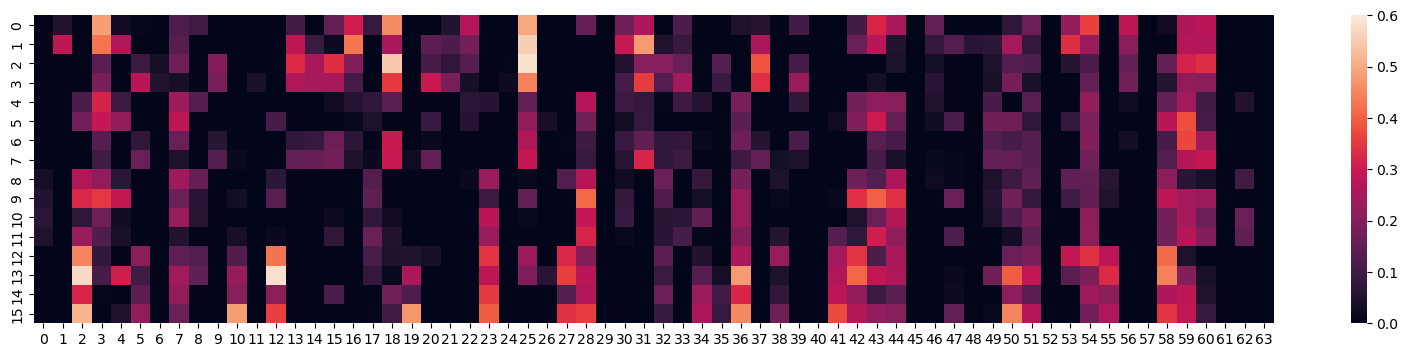

In [38]:
f, ax = plt.subplots(figsize=(20, 4))
sns.heatmap(embeddings, annot=False, vmin=0, vmax=0.6)
plt.show()

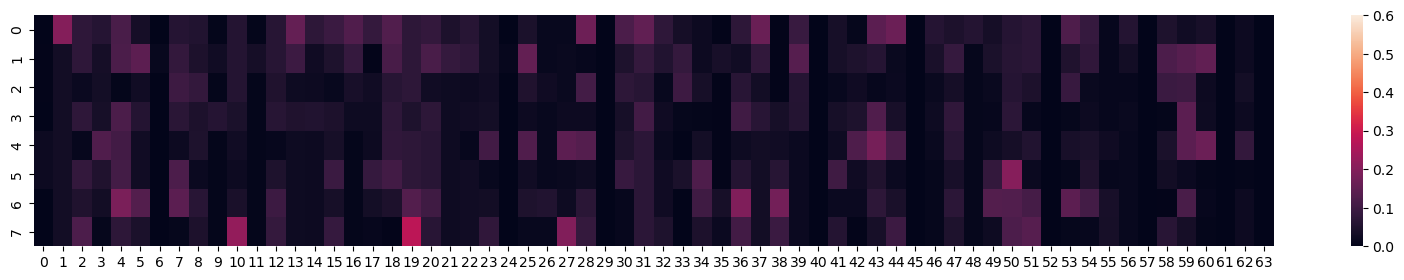

In [44]:
# make the difference vector and concatenate to original matrix
vectors_p_minus_m = np.concatenate(
    [
        (embeddings[0] - embeddings[1]).reshape(1, -1), 
        (embeddings[2] - embeddings[3]).reshape(1, -1),
        (embeddings[4] - embeddings[5]).reshape(1, -1),
        (embeddings[6] - embeddings[7]).reshape(1, -1),
        (embeddings[8] - embeddings[9]).reshape(1, -1),
        (embeddings[10] - embeddings[11]).reshape(1, -1),
        (embeddings[12] - embeddings[13]).reshape(1, -1),
        (embeddings[14] - embeddings[15]).reshape(1, -1),
     ]
, axis=0)

vector_p_minus_m = vectors_p_minus_m.mean(axis=0)

show = np.absolute(vectors_p_minus_m - vector_p_minus_m)

f, ax = plt.subplots(figsize=(20, 3))
sns.heatmap(show, annot=False, vmin=0, vmax=0.6)
plt.show()

In [42]:
vectors_p_minus_m = np.absolute(np.concatenate(
    [
        (embeddings[0] - embeddings[1]).reshape(1, -1), 
        (embeddings[2] - embeddings[3]).reshape(1, -1),
        (embeddings[4] - embeddings[5]).reshape(1, -1),
        (embeddings[6] - embeddings[7]).reshape(1, -1),
        (embeddings[8] - embeddings[9]).reshape(1, -1),
        (embeddings[10] - embeddings[11]).reshape(1, -1),
        (embeddings[12] - embeddings[13]).reshape(1, -1),
        (embeddings[14] - embeddings[15]).reshape(1, -1),
     ]
, axis=0))

vectors_p_minus_m.mean(axis=0)


array([0.00602573, 0.02855643, 0.07415348, 0.04567052, 0.11786643,
       0.0549354 , 0.00199313, 0.08730254, 0.05028524, 0.01088644,
       0.05698757, 0.00498105, 0.0632402 , 0.04038516, 0.02117763,
       0.05328418, 0.03512905, 0.03429996, 0.08366334, 0.0715825 ,
       0.07358359, 0.02134775, 0.02649966, 0.04376442, 0.00163125,
       0.06045372, 0.0127427 , 0.04775168, 0.07613739, 0.        ,
       0.05141847, 0.0695857 , 0.03742649, 0.03350572, 0.04650132,
       0.01186642, 0.07381605, 0.04214031, 0.04884708, 0.04722787,
       0.        , 0.03562298, 0.04791732, 0.11323264, 0.07018889,
       0.        , 0.02044958, 0.08457217, 0.0081292 , 0.0494055 ,
       0.13259809, 0.06716137, 0.        , 0.05606045, 0.0541455 ,
       0.01363613, 0.01748989, 0.        , 0.05503094, 0.08831376,
       0.06133511, 0.        , 0.02103087, 0.        ], dtype=float32)

# Bar plot

In [11]:
import matplotlib

def save_fig(ax,file_path):
    matplotlib.rcParams['pdf.fonttype'] = 42
    matplotlib.rcParams['ps.fonttype'] = 42
    plt = ax.get_figure()
    plt.savefig(file_path, transparent=True)
    return

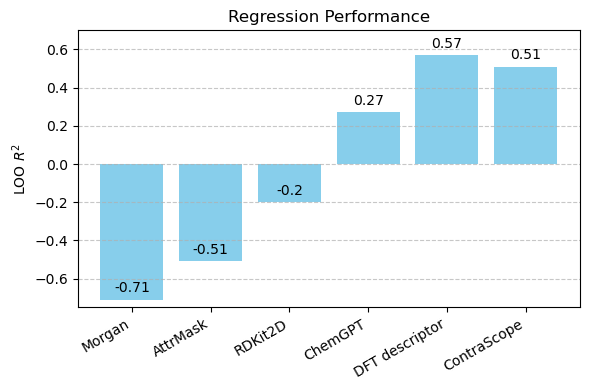

In [26]:
# Sample data for the bar plot
categories = ['Morgan', 'AttrMask', 'RDKit2D', 'ChemGPT', 'DFT descriptor', 'ContraScope']
values = [-0.71, -0.51, -0.20, 0.27, 0.57, 0.51]

# Creating the bar plot
fig, ax = plt.subplots(figsize=(6, 4))

# Adding the bars
bars = ax.bar(categories, values, color='skyblue')

# Adding value labels on top of each bar
for bar in bars:
    height = bar.get_height()
    ax.annotate(f'{height}',
                xy=(bar.get_x() + bar.get_width() / 2, height),
                xytext=(0, 3),  # 3 points vertical offset
                textcoords="offset points",
                ha='center', va='bottom')

# Setting the title and labels
ax.set_title('Regression Performance')
# ax.set_xlabel('Embed')
ax.set_ylabel(r'LOO $R^2$')
ax.set_ylim((-0.75, 0.7))
plt.xticks(rotation=30, ha='right')

# Adding a grid for better readability
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()

save_fig(ax, './regression_performance.pdf')

# plt.show()